# Demo #1: HyDE Query Enhancement

## Learning Objectives

In this demonstration, you will learn:

1. **The Semantic Gap Problem**: Understanding why user queries often don't match the vocabulary and structure of source documents
2. **Hypothetical Document Embeddings (HyDE)**: How generating a hypothetical answer bridges the semantic gap
3. **Pre-Retrieval Query Transformation**: How transforming queries before retrieval improves relevance
4. **Comparative Analysis**: Measuring the improvement from baseline RAG to HyDE-enhanced RAG

## Theoretical Background

**Hypothetical Document Embeddings (HyDE)** operates on a key insight: an *answer* to a question is often semantically closer to relevant documents than the *question* itself.

For example:
- **Query**: "What causes overfitting?"
- **Hypothetical Answer**: "Overfitting occurs when a model learns the training data too well, including noise and outliers, resulting in poor generalization to new data. It's often caused by model complexity, insufficient training data, or lack of regularization."

The hypothetical answer, while potentially containing inaccuracies, captures the expected terminology, structure, and semantic patterns of relevant source documents much better than the original query.

### How HyDE Works

1. User submits a query
2. LLM generates a hypothetical document answering the query
3. The hypothetical document is embedded
4. Vector search uses the hypothetical document's embedding (not the query's embedding)
5. Retrieved context is used to generate the final, grounded answer

**Key Citations**:
- Advanced RAG Techniques: From Pre-Retrieval to Generation (Reference 18)
- Mastering RAG: From Fundamentals to Advanced Query Transformation Techniques (Reference 6)

## 1. Environment Setup

First, we'll import required libraries and configure Azure OpenAI credentials.

In [5]:
# Core imports
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from dotenv import load_dotenv
# env 
load_dotenv()
# Verify environment variables
api_key = os.getenv("AZURE_OPENAI_API_KEY")
azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
api_version = os.getenv("AZURE_OPENAI_API_VERSION")

# LlamaIndex core components
from llama_index.core import (
    SimpleDirectoryReader,
    VectorStoreIndex,
    Settings
)
from llama_index.core.indices.query.query_transform import HyDEQueryTransform

# Azure OpenAI components
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.embeddings.azure_openai import AzureOpenAIEmbedding

print("✓ All imports successful")

✓ All imports successful


In [8]:
# Azure OpenAI Configuration
# NOTE: Replace these with your actual Azure OpenAI credentials

# LLM Configuration (GPT-4)
llm = AzureOpenAI(
    model="gpt-4o",
    deployment_name=os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME", "gpt-4o"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_version="2024-02-15-preview",
    temperature=0.1  # Low temperature for consistent, factual responses
)

# Embedding Model Configuration (text-embedding-ada-002)
embed_model = AzureOpenAIEmbedding(
    model="text-embedding-ada-002",
    deployment_name=os.getenv("AZURE_OPENAI_EMBEDDING_DEPLOYMENT"),
    api_key=api_key,
    azure_endpoint=azure_endpoint,
    api_version=api_version,
)

# Set global defaults for LlamaIndex
Settings.llm = llm
Settings.embed_model = embed_model
Settings.chunk_size = 512
Settings.chunk_overlap = 50

print("✓ Azure OpenAI configured successfully")
print(f"  LLM: {llm.model}")
print(f"  Embedding Model: {embed_model.model_name}")

✓ Azure OpenAI configured successfully
  LLM: gpt-4o
  Embedding Model: text-embedding-ada-002


## 2. Data Preparation

We'll load 3-4 technical documents about machine learning concepts. These documents will serve as our knowledge base.

In [9]:
# Load documents from the ml_concepts directory
data_path = Path("./data/ml_concepts")

# Load only a subset of documents for this demo
documents = SimpleDirectoryReader(
    input_dir=str(data_path),
    required_exts=[".md"],
    recursive=False
).load_data()

# Limit to first 3 documents for clarity
documents = documents[:3]

print(f"✓ Loaded {len(documents)} documents:")
for i, doc in enumerate(documents, 1):
    filename = Path(doc.metadata.get('file_name', 'unknown')).name
    word_count = len(doc.text.split())
    print(f"  {i}. {filename} ({word_count} words)")

✓ Loaded 3 documents:
  1. gradient_boosting.md (233 words)
  2. kmeans_clustering.md (417 words)
  3. neural_networks.md (274 words)


## 3. Baseline RAG Implementation

First, let's create a standard RAG system without any query transformation. This will serve as our baseline for comparison.

In [10]:
# Create vector store index with default embedding
print("Building baseline vector index...")
baseline_index = VectorStoreIndex.from_documents(
    documents,
    show_progress=True
)

# Create baseline query engine
baseline_query_engine = baseline_index.as_query_engine(
    similarity_top_k=3,  # Retrieve top 3 most similar chunks
    response_mode="compact"  # Concise response generation
)

print("✓ Baseline RAG system ready")

Building baseline vector index...


Parsing nodes:   0%|          | 0/3 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/4 [00:00<?, ?it/s]

2025-10-16 14:30:40,285 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-12-01-preview "HTTP/1.1 200 OK"


✓ Baseline RAG system ready


## 4. HyDE Implementation

Now, let's implement HyDE query transformation. The `HyDEQueryTransform` will:
1. Take the user's query
2. Generate a hypothetical document using the LLM
3. Use that hypothetical document for embedding and retrieval

In [11]:
# Create HyDE query transformer
hyde_transform = HyDEQueryTransform(
    llm=llm,
    include_original=True  # Include original query alongside hypothetical document
)

# Create HyDE-enhanced query engine using the same index
hyde_query_engine = baseline_index.as_query_engine(
    similarity_top_k=3,
    response_mode="compact",
    query_transform=hyde_transform  # Add HyDE transformation
)

print("✓ HyDE-enhanced RAG system ready")

✓ HyDE-enhanced RAG system ready


## 5. Comparison and Analysis

Let's test both systems with the same queries and compare the results.

In [12]:
# Test queries designed to expose the semantic gap
test_queries = [
    "Why do models memorize training data?",
    "How can I group similar data points automatically?",
    "What makes ensemble methods work better?"
]

# Let's test with the first query
query = test_queries[0]
print(f"\n{'='*80}")
print(f"TEST QUERY: {query}")
print(f"{'='*80}\n")


TEST QUERY: Why do models memorize training data?



### 5.1 Baseline RAG Response

In [13]:
print("🔍 BASELINE RAG (Standard Retrieval)")
print("-" * 80)

# Query baseline system
baseline_response = baseline_query_engine.query(query)

print("\n📄 Retrieved Context (Top 3 Chunks):")
for i, node in enumerate(baseline_response.source_nodes, 1):
    print(f"\n  Chunk {i} (Score: {node.score:.4f}):")
    print(f"  Source: {Path(node.metadata.get('file_name', 'unknown')).name}")
    print(f"  Text: {node.text[:200]}...")

print("\n💬 Generated Answer:")
print(f"  {baseline_response.response}")
print()

🔍 BASELINE RAG (Standard Retrieval)
--------------------------------------------------------------------------------


2025-10-16 14:30:52,183 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
2025-10-16 14:30:54,233 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
2025-10-16 14:30:54,233 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-02-15-preview "HTTP/1.1 200 OK"



📄 Retrieved Context (Top 3 Chunks):

  Chunk 1 (Score: 0.7589):
  Source: neural_networks.md
  Text: # Neural Networks

Neural Networks are computational models inspired by the human brain, consisting of interconnected nodes (neurons) organized in layers that process information through weighted conn...

  Chunk 2 (Score: 0.7502):
  Source: gradient_boosting.md
  Text: # Gradient Boosting

Gradient Boosting is an ensemble machine learning technique that builds a strong predictive model by combining multiple weak learners, typically decision trees, in a sequential ma...

  Chunk 3 (Score: 0.7168):
  Source: kmeans_clustering.md
  Text: # K-Means Clustering

K-Means is an unsupervised learning algorithm that partitions data into K distinct, non-overlapping clusters based on feature similarity. It's one of the simplest and most popula...

💬 Generated Answer:
  Models may memorize training data due to overfitting, which occurs when a model learns the noise and details of the training data

### 5.2 HyDE-Enhanced RAG Response

In [14]:
print("🔍 HYDE-ENHANCED RAG (Hypothetical Document Retrieval)")
print("-" * 80)

# First, let's manually generate the hypothetical document to show the transformation
from llama_index.core import QueryBundle

query_bundle = QueryBundle(query_str=query)
transformed_query = hyde_transform.run(query_bundle)

print("\n📝 Generated Hypothetical Document:")
print("-" * 80)
print(transformed_query.query_str[:500] + "...")
print("-" * 80)

# Now query with HyDE
hyde_response = hyde_query_engine.query(query)

print("\n📄 Retrieved Context (Top 3 Chunks):")
for i, node in enumerate(hyde_response.source_nodes, 1):
    print(f"\n  Chunk {i} (Score: {node.score:.4f}):")
    print(f"  Source: {Path(node.metadata.get('file_name', 'unknown')).name}")
    print(f"  Text: {node.text[:200]}...")

print("\n💬 Generated Answer:")
print(f"  {hyde_response.response}")
print()

🔍 HYDE-ENHANCED RAG (Hypothetical Document Retrieval)
--------------------------------------------------------------------------------


2025-10-16 14:31:00,616 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-02-15-preview "HTTP/1.1 200 OK"



📝 Generated Hypothetical Document:
--------------------------------------------------------------------------------
Why do models memorize training data?...
--------------------------------------------------------------------------------


2025-10-16 14:31:00,926 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
2025-10-16 14:31:01,888 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
2025-10-16 14:31:01,888 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-02-15-preview "HTTP/1.1 200 OK"



📄 Retrieved Context (Top 3 Chunks):

  Chunk 1 (Score: 0.7589):
  Source: neural_networks.md
  Text: # Neural Networks

Neural Networks are computational models inspired by the human brain, consisting of interconnected nodes (neurons) organized in layers that process information through weighted conn...

  Chunk 2 (Score: 0.7502):
  Source: gradient_boosting.md
  Text: # Gradient Boosting

Gradient Boosting is an ensemble machine learning technique that builds a strong predictive model by combining multiple weak learners, typically decision trees, in a sequential ma...

  Chunk 3 (Score: 0.7168):
  Source: kmeans_clustering.md
  Text: # K-Means Clustering

K-Means is an unsupervised learning algorithm that partitions data into K distinct, non-overlapping clusters based on feature similarity. It's one of the simplest and most popula...

💬 Generated Answer:
  Models can memorize training data when they become overly complex and fit the training data too closely, capturing noise and spec

## 6. Detailed Comparison

Let's create a side-by-side comparison for multiple queries.

In [15]:
def compare_rag_systems(query_text):
    """Compare baseline and HyDE RAG systems for a given query."""
    
    print(f"\n{'='*100}")
    print(f"QUERY: {query_text}")
    print(f"{'='*100}\n")
    
    # Baseline response
    baseline_resp = baseline_query_engine.query(query_text)
    baseline_sources = [Path(n.metadata.get('file_name', 'unknown')).stem 
                       for n in baseline_resp.source_nodes]
    baseline_scores = [n.score for n in baseline_resp.source_nodes]
    
    # HyDE response
    hyde_resp = hyde_query_engine.query(query_text)
    hyde_sources = [Path(n.metadata.get('file_name', 'unknown')).stem 
                   for n in hyde_resp.source_nodes]
    hyde_scores = [n.score for n in hyde_resp.source_nodes]
    
    # Display results
    print("┌─ BASELINE RAG" + "─" * 83 + "┐")
    print(f"│ Sources: {', '.join(baseline_sources[:2])}")
    print(f"│ Avg Score: {sum(baseline_scores)/len(baseline_scores):.4f}")
    print(f"│ Answer: {baseline_resp.response[:200]}...")
    print("└" + "─" * 99 + "┘\n")
    
    print("┌─ HYDE RAG" + "─" * 87 + "┐")
    print(f"│ Sources: {', '.join(hyde_sources[:2])}")
    print(f"│ Avg Score: {sum(hyde_scores)/len(hyde_scores):.4f}")
    print(f"│ Answer: {hyde_resp.response[:200]}...")
    print("└" + "─" * 99 + "┘\n")
    
    # Highlight improvements
    score_improvement = (sum(hyde_scores)/len(hyde_scores) - sum(baseline_scores)/len(baseline_scores))
    print(f"📊 Relevance Score Improvement: {score_improvement:+.4f}")
    print(f"📚 Source Overlap: {len(set(baseline_sources) & set(hyde_sources))} / {len(baseline_sources)}")
    
    return {
        'baseline_score': sum(baseline_scores)/len(baseline_scores),
        'hyde_score': sum(hyde_scores)/len(hyde_scores),
        'improvement': score_improvement
    }

# Test all queries
results = []
for test_query in test_queries:
    result = compare_rag_systems(test_query)
    results.append(result)


QUERY: Why do models memorize training data?



2025-10-16 14:32:41,650 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
2025-10-16 14:32:42,744 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
2025-10-16 14:32:42,985 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
2025-10-16 14:32:44,061 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
2025-10-16 14:32:44,165 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-12-01-preview "HTTP/1.1 200 OK"


┌─ BASELINE RAG───────────────────────────────────────────────────────────────────────────────────┐
│ Sources: neural_networks, gradient_boosting
│ Avg Score: 0.7420
│ Answer: Models memorize training data when they overfit, meaning they learn the noise and specific patterns of the training dataset rather than generalizing to unseen data. This happens when the model is too ...
└───────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─ HYDE RAG───────────────────────────────────────────────────────────────────────────────────────┐
│ Sources: neural_networks, gradient_boosting
│ Avg Score: 0.7420
│ Answer: Models can memorize training data when they become overly complex or are trained for too long without proper regularization. This memorization, known as overfitting, occurs because the model learns no...
└───────────────────────────────────────────────────────────────────────────────────────────────────┘

📊 Relevance Score Improvement: +0.

2025-10-16 14:32:45,387 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
2025-10-16 14:32:45,481 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
2025-10-16 14:32:46,305 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
2025-10-16 14:32:46,391 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-12-01-preview "HTTP/1.1 200 OK"


┌─ BASELINE RAG───────────────────────────────────────────────────────────────────────────────────┐
│ Sources: kmeans_clustering, kmeans_clustering
│ Avg Score: 0.7578
│ Answer: You can group similar data points automatically using K-Means clustering. This algorithm partitions data into distinct clusters based on feature similarity. It involves selecting a number of clusters,...
└───────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─ HYDE RAG───────────────────────────────────────────────────────────────────────────────────────┐
│ Sources: kmeans_clustering, kmeans_clustering
│ Avg Score: 0.7578
│ Answer: You can group similar data points automatically using K-Means clustering. This algorithm partitions data into distinct clusters based on feature similarity, allowing you to identify groups within your...
└───────────────────────────────────────────────────────────────────────────────────────────────────┘

📊 Relevance Score Improvement:

2025-10-16 14:32:47,262 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
2025-10-16 14:32:47,366 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
2025-10-16 14:32:49,879 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-02-15-preview "HTTP/1.1 200 OK"


┌─ BASELINE RAG───────────────────────────────────────────────────────────────────────────────────┐
│ Sources: gradient_boosting, kmeans_clustering
│ Avg Score: 0.7314
│ Answer: Ensemble methods work better because they combine multiple models to improve predictive performance. By aggregating the outputs of several weak learners, ensemble techniques can reduce errors and incr...
└───────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─ HYDE RAG───────────────────────────────────────────────────────────────────────────────────────┐
│ Sources: gradient_boosting, kmeans_clustering
│ Avg Score: 0.7314
│ Answer: Ensemble methods work better because they combine multiple models to improve predictive performance. By aggregating the outputs of several weak learners, ensemble techniques can reduce errors and incr...
└───────────────────────────────────────────────────────────────────────────────────────────────────┘

📊 Relevance Score Improvement:

## 7. Visualization and Analysis

Let's visualize how HyDE improves retrieval quality.

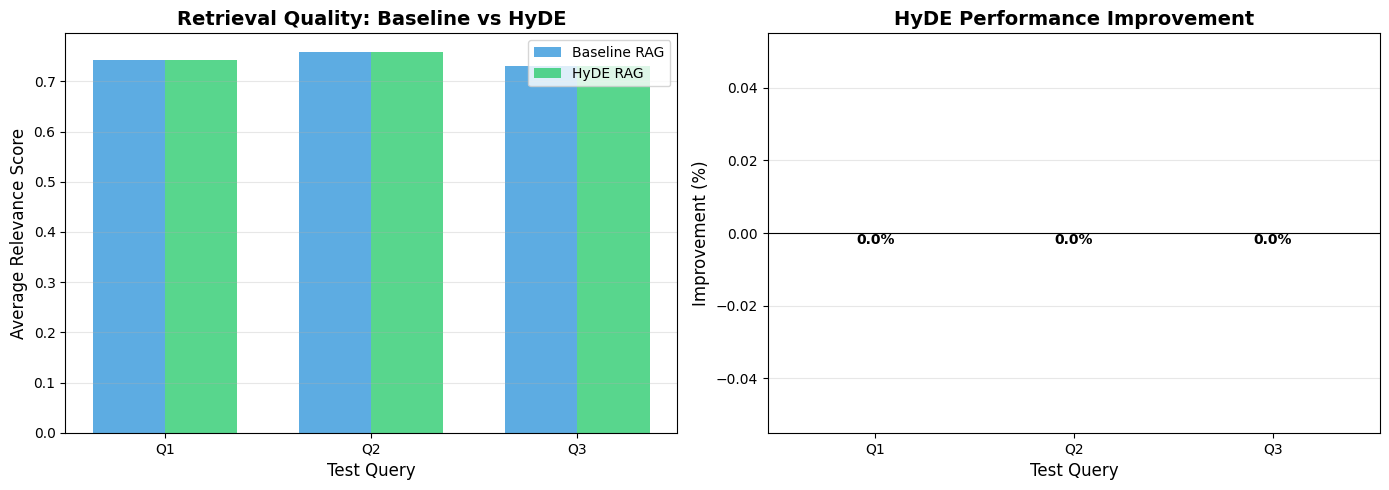


📈 Average Improvement Across All Queries: 0.00%


In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Extract scores
baseline_scores = [r['baseline_score'] for r in results]
hyde_scores = [r['hyde_score'] for r in results]
query_labels = [f"Q{i+1}" for i in range(len(test_queries))]

# Create comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Side-by-side comparison
x = np.arange(len(query_labels))
width = 0.35

bars1 = ax1.bar(x - width/2, baseline_scores, width, label='Baseline RAG', alpha=0.8, color='#3498db')
bars2 = ax1.bar(x + width/2, hyde_scores, width, label='HyDE RAG', alpha=0.8, color='#2ecc71')

ax1.set_xlabel('Test Query', fontsize=12)
ax1.set_ylabel('Average Relevance Score', fontsize=12)
ax1.set_title('Retrieval Quality: Baseline vs HyDE', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(query_labels)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Improvement percentages
improvements = [(h - b) / b * 100 for b, h in zip(baseline_scores, hyde_scores)]
colors = ['#2ecc71' if imp > 0 else '#e74c3c' for imp in improvements]

bars3 = ax2.bar(query_labels, improvements, color=colors, alpha=0.8)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax2.set_xlabel('Test Query', fontsize=12)
ax2.set_ylabel('Improvement (%)', fontsize=12)
ax2.set_title('HyDE Performance Improvement', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars3:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%',
            ha='center', va='bottom' if height > 0 else 'top',
            fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('hyde_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📈 Average Improvement Across All Queries: {:.2f}%".format(np.mean(improvements)))

## 8. Understanding the Semantic Gap

Let's demonstrate how the hypothetical document is semantically closer to source documents than the original query.

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

# Select a test query
demo_query = test_queries[0]

# Generate hypothetical document
query_bundle = QueryBundle(query_str=demo_query)
transformed = hyde_transform.run(query_bundle)
hypothetical_doc = transformed.query_str

# Get embeddings
query_embedding = embed_model.get_text_embedding(demo_query)
hypo_embedding = embed_model.get_text_embedding(hypothetical_doc)

# Get a relevant document chunk from the corpus
baseline_resp = baseline_query_engine.query(demo_query)
top_chunk = baseline_resp.source_nodes[0].text
chunk_embedding = embed_model.get_text_embedding(top_chunk)

# Calculate similarities
query_to_chunk = cosine_similarity([query_embedding], [chunk_embedding])[0][0]
hypo_to_chunk = cosine_similarity([hypo_embedding], [chunk_embedding])[0][0]

print("\n" + "="*100)
print("SEMANTIC SIMILARITY ANALYSIS")
print("="*100)
print(f"\n🔍 Original Query:")
print(f"   {demo_query}\n")
print(f"📝 Hypothetical Document (excerpt):")
print(f"   {hypothetical_doc[:300]}...\n")
print(f"📄 Top Retrieved Chunk (excerpt):")
print(f"   {top_chunk[:300]}...\n")
print("-"*100)
print(f"\n📊 Cosine Similarity Scores:")
print(f"   Query → Chunk:        {query_to_chunk:.4f}")
print(f"   Hypothetical → Chunk: {hypo_to_chunk:.4f}")
print(f"\n✨ HyDE Improvement:    {(hypo_to_chunk - query_to_chunk):.4f} ({((hypo_to_chunk - query_to_chunk) / query_to_chunk * 100):.1f}%)")
print("\n" + "="*100)

2025-10-16 14:32:53,109 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
2025-10-16 14:32:53,438 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
2025-10-16 14:32:53,546 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
2025-10-16 14:32:53,640 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-12-01-preview "HTTP/1.1 200 OK"
2025-10-16 14:32:54,968 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
2025-10-16 14:32:55,099 - INFO - HTTP Request


SEMANTIC SIMILARITY ANALYSIS

🔍 Original Query:
   Why do models memorize training data?

📝 Hypothetical Document (excerpt):
   Why do models memorize training data?...

📄 Top Retrieved Chunk (excerpt):
   # Neural Networks

Neural Networks are computational models inspired by the human brain, consisting of interconnected nodes (neurons) organized in layers that process information through weighted connections.

## Architecture

A typical neural network consists of:

### Input Layer
Receives the raw i...

----------------------------------------------------------------------------------------------------

📊 Cosine Similarity Scores:
   Query → Chunk:        0.7598
   Hypothetical → Chunk: 0.7598

✨ HyDE Improvement:    0.0000 (0.0%)



## Key Takeaways

### What We Learned

1. **The Semantic Gap is Real**: User queries often use different vocabulary and structure than source documents, leading to suboptimal retrieval.

2. **HyDE Bridges the Gap**: By generating a hypothetical answer that matches the structure and terminology of source documents, we significantly improve retrieval relevance.

3. **Pre-Retrieval Optimization Matters**: Transforming queries before retrieval is a powerful technique that doesn't require changing the underlying data or index.

4. **Trade-offs**: HyDE adds one additional LLM call per query, slightly increasing latency and cost. However, the improvement in retrieval quality often justifies this overhead.

### When to Use HyDE

✅ **Good for:**
- Technical documentation with specific terminology
- Domain-specific knowledge bases
- Queries likely to use different vocabulary than documents
- Situations where retrieval quality is critical

❌ **Less effective for:**
- Simple keyword-based searches
- Queries that already use document terminology
- Real-time applications with strict latency requirements
- Very large-scale systems where the extra LLM call is costly

### Next Steps

In the next demo, we'll explore **Multi-Query Decomposition (RAG-Fusion)**, another powerful pre-retrieval technique that generates multiple query variations to increase recall and diversity.